In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
N_DONORS=4 


In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

fig_utils from mplh
here
0.4.2


In [4]:
AD_F = join(INDIR, "cellSNP.tag.AD.mtx")
DP_F = join(INDIR, "cellSNP.tag.DP.mtx")
cell_inds_names = join(INDIR,"cell_indices_*.txt")

# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

## Load cluster results and test for enrichment

In [33]:
def extract_clusters(modelCA, ad, dp, sample_colors, prob_thresh=0.9, doublet_thresh=0.9):
    """ Creates a dictionary where the keys are the cluster IDs (0-based index)
        and the values are the cell indices (0-based index)"""
    cell_clusters = {}
    sample_labels = {}
    doublet_prob = modelCA.predict_doublet(ad, dp, 
                                       update_GT=False, 
                                       update_ID=False)[0].sum(axis=1)
    low_conf_cells = np.flatnonzero(doublet_prob > doublet_thresh)
    for n in range(modelCA.ID_prob.shape[1]):
        cell_clusters[n] = np.flatnonzero((modelCA.ID_prob[:,n]>prob_thresh))
        cell_clusters[n] = cell_clusters[n][~(np.isin(cell_clusters[n], low_conf_cells))]
        curr_sample_colors = sample_colors.iloc[cell_clusters[n]].copy()
        curr_sample_colors = curr_sample_colors.reset_index()
        sample_labels[n] = curr_sample_colors
        print(f"Cluster {n}: {len(cell_clusters[n])} cells ")
    
    return cell_clusters, sample_labels

def run_enrichment(df):
    """Runs hypergeometric for flt3 expansion. 
    
    df: pd.DataFrame where index is Control and Flt3, columns are cluster labels, and elements are number of cells.
    """
    enrichment_df = pd.DataFrame(index=["p"], 
                                 columns=df.columns)
    
    #M: Total number of cells
    #n: Number of cells in the clone
    #N: Number of flt3 cells
    #x: Number of cells in specific clone with flt3
    M = df.sum().sum()
    N = df.loc["Flt3"].sum()
    #rv = hypergeom(M, n, N)
    for col in df.columns:
        n = df[col].sum()
        x = df.loc["Flt3", col]
        prb = 1-hypergeom.cdf(x, M, n, N)
        enrichment_df.loc["p", col] = prb
    return enrichment_df

data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0.AD.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0.DP.txt
Cluster 0: 1216 cells 
Cluster 1: 31 cells 
Cluster 2: 945 cells 
Cluster 3: 12 cells 
Cluster 4: 48 cells 
Cluster 5: 52 cells 
Cluster 6: 599 cells 
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster1.AD.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster1.DP.txt
Cluster 0: 265 cells 
Cluster 1: 11 cells 
Cluster 2: 80 cells 
Cluster 3: 35 cells 
Cluster 4: 1629 cells 
Cluster 5: 1180 cells 
Cluster 6: 7 cells 
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2.AD.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2.DP.txt
Cluster 0: 142 cells 
Cluster 1: 164 cells 
Cluster 2: 279 cells 
Cluster 3: 309 cells 
Cluster 4: 56 cells 
Cluster 5: 698 cells 
Cluster 6: 267 cells 
data/jan21_

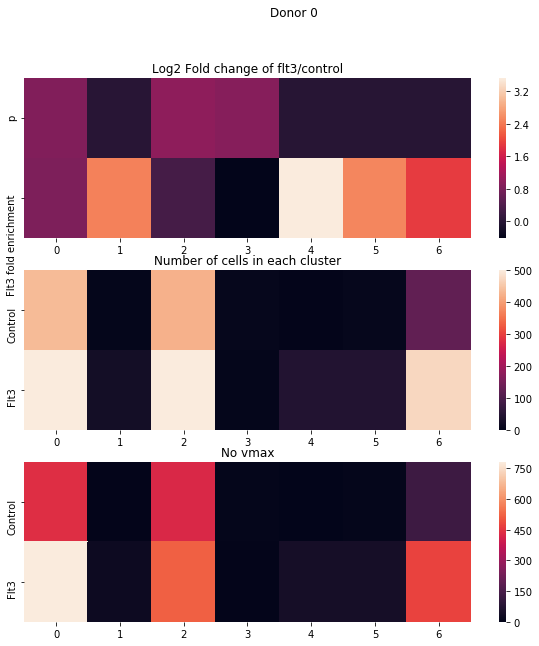

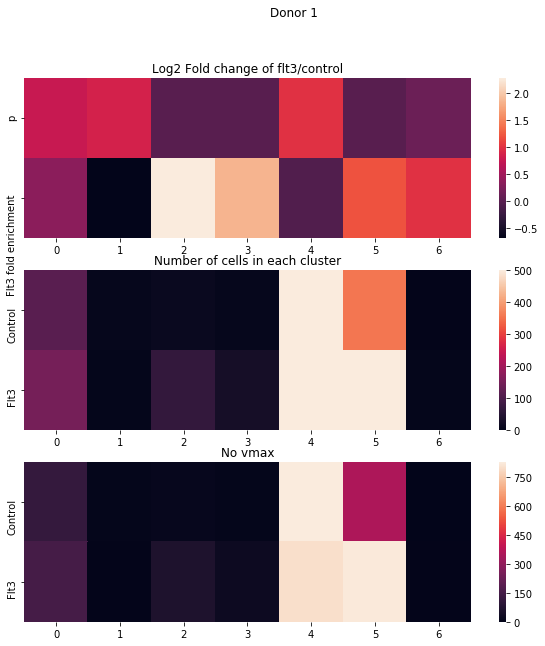

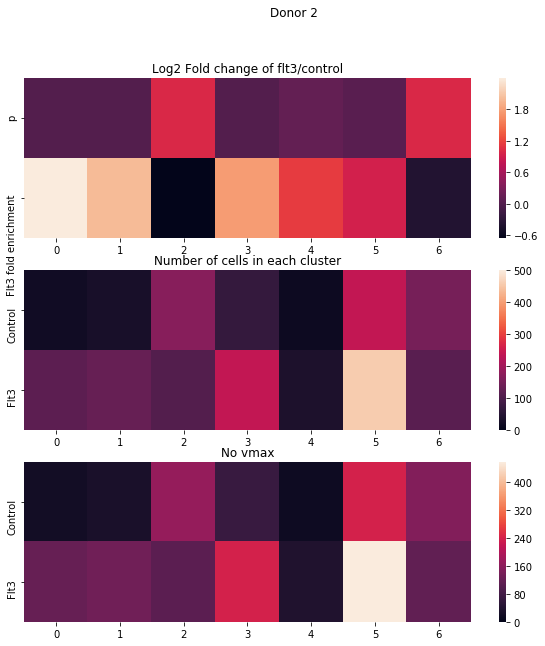

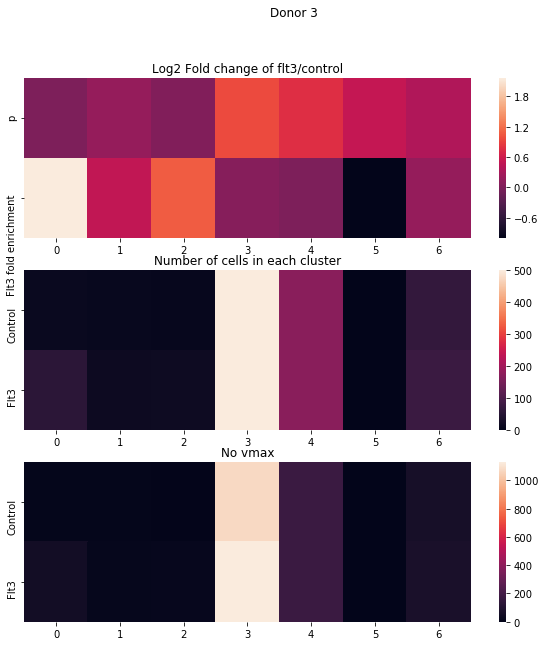

In [42]:
n_clone_list = [7]#[2,3,4,5,6,7]

for n in range(N_DONORS):
    curr_ad_f = join(OUTDIR, f"cluster{n}.AD.txt")
    curr_dp_f = join(OUTDIR, f"cluster{n}.DP.txt")
    print(curr_ad_f)
    print(curr_dp_f)
    curr_ad = mmread(curr_ad_f).tocsc()
    curr_dp = mmread(curr_dp_f).tocsc()
    curr_labels = pd.read_csv(join(OUTDIR, f"cluster{n}.labels.txt"), index_col=0)
    out_f = join(OUTDIR, f"cluster{n}_lineage_elbow.png")
    for k in n_clone_list:
        curr_modelCA = pickle.load(open(out_f+f"clones{k}.modelCA.p", "rb"))
        cell_clusters, sample_labels = extract_clusters(curr_modelCA, curr_ad, curr_dp, 
                                                        curr_labels)
        # Create counts df 
        clust_counts = pd.DataFrame(index=["Control", "Flt3"], 
                                 columns=sample_labels.keys())
        for k in clust_counts.columns:
            clust_counts.at["Control", k] = (sample_labels[k]["sample ID"] == "Control").sum()
            clust_counts.at["Flt3", k] = (sample_labels[k]["sample ID"] == "Flt3").sum()
        clust_counts = clust_counts.astype(int)
        
        
        # Get enrichment
        enrich_df = run_enrichment(clust_counts)
        fold_df = pd.DataFrame(np.log2((clust_counts.loc["Flt3"]+1)/(clust_counts.loc["Control"]+1))).transpose()
        fold_df = fold_df.rename({0:"Flt3 fold enrichment"}, axis=0)
        
        
        f, ax = plt.subplots(nrows=3, ncols=1 ,figsize=(10,10))
        sns.heatmap(pd.concat((enrich_df, fold_df), axis=0).astype(np.double), ax=ax[0])
        
        ax[0].set_title("Log2 Fold change of flt3/control")
        plt.xlabel("log2((Flt3+1)/(WT+1))")
        #plt.savefig(out_f+f"clones{k}_labelChange.png")
        sns.heatmap((clust_counts.astype(int)), vmin=0, vmax=500, ax=ax[1])
        ax[1].set_title("Number of cells in each cluster")
        #plt.savefig(out_f+f"clones{k}_labelCounts.png")
        sns.heatmap((clust_counts.astype(int)), vmin=0, ax=ax[2])
        ax[2].set_title("No vmax")
        plt.suptitle(f"Donor {n}")
        plt.savefig(out_f+f"clones{k}_labelEnrich.png")
        